will do the explotory_analysis on the cleaned data

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
df_final=pd.read_csv(BRONZE_DIR / "ncdb_merged_filtered.csv")

In [23]:
if df_final['Report_Date'].dtype == 'object':
    df_final['Report_Date'] = pd.to_datetime(df_final['Report_Date'])

In [24]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

In [25]:
monthly_demand = (
    df_final
    .groupby("Report_Date")
    .size()
    .reset_index(name="Incident_Count")
)

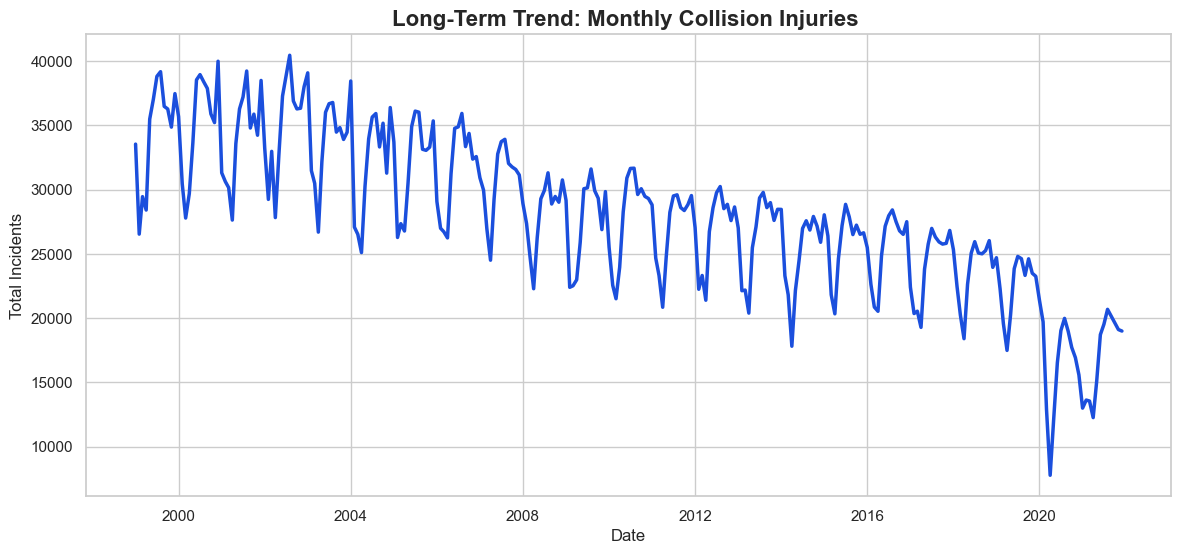

In [26]:
plt.figure()
sns.lineplot(data=monthly_demand, x="Report_Date", y="Incident_Count", color="#1b4fdd", linewidth=2.5)
plt.title("Long-Term Trend: Monthly Collision Injuries ", fontsize=16, fontweight='bold')
plt.ylabel("Total Incidents")
plt.xlabel("Date")
plt.show()

In [27]:
seasonal_pattern = (
    df_final
    .groupby("C_MNTH")
    .size()
    .reset_index(name="Avg_Incidents")
)

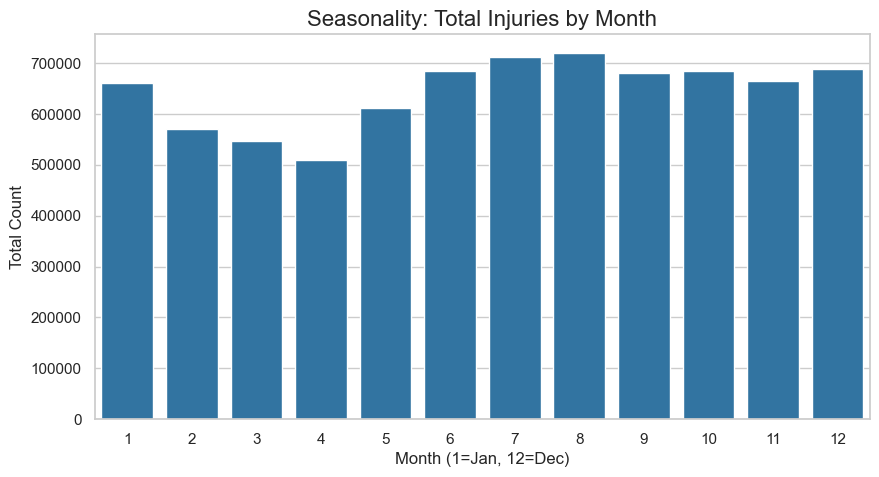

In [28]:
plt.figure(figsize=(10, 5))
sns.barplot(data=seasonal_pattern, x="C_MNTH", y="Avg_Incidents", color="#1f77b4")
plt.title("Seasonality: Total Injuries by Month", fontsize=16)
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Total Count")
plt.show()

In [29]:
hourly_risk = (
    df_final[df_final["C_HOUR"] != -1]
    .groupby("C_HOUR")
    .size()
    .reset_index(name="Count")
)

C:\Users\rajpu\AppData\Local\Temp\ipykernel_18936\466419022.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_risk, x="C_HOUR", y="Count", palette="Reds_d")


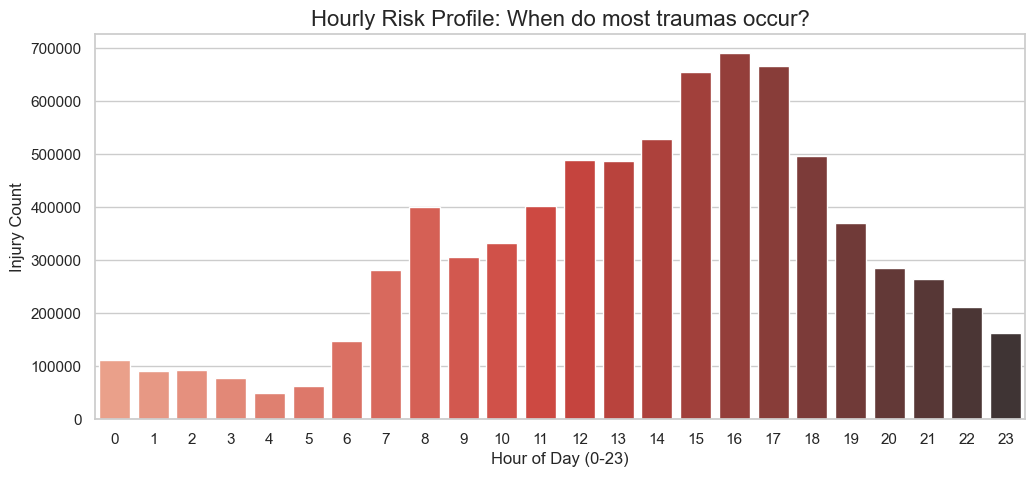

In [30]:
plt.figure(figsize=(12, 5))
sns.barplot(data=hourly_risk, x="C_HOUR", y="Count", palette="Reds_d")
plt.title("Hourly Risk Profile: When do most traumas occur?", fontsize=16)
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Injury Count")
plt.show()

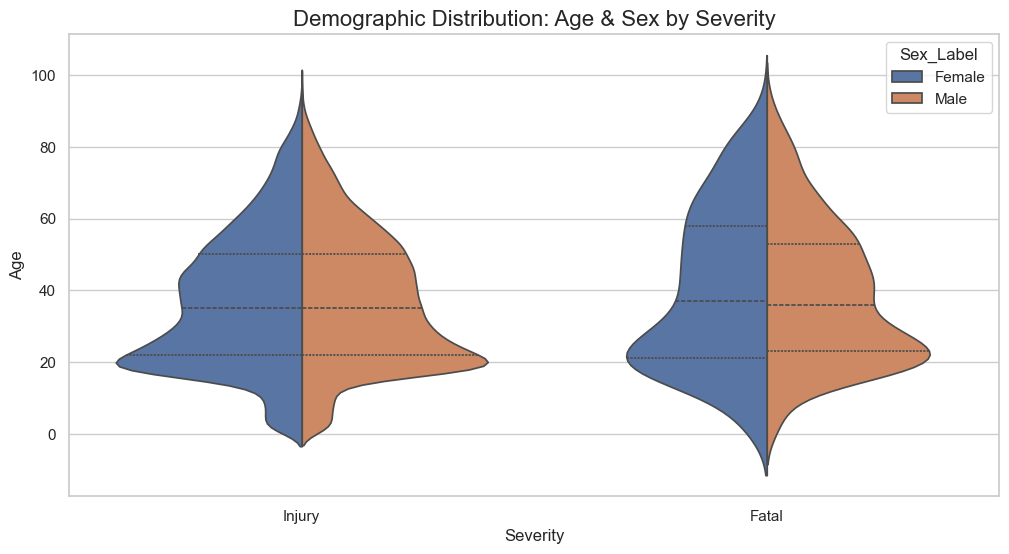

In [31]:
if 'Sex_Label' in df_final.columns and 'Severity_Label' in df_final.columns:
    # Filter "Unknown" sex and sample 100k rows for performance
    demo_dist = (
        df_final[df_final["Sex_Label"] != "Unknown"]
        [['P_AGE', 'Sex_Label', 'Severity_Label']]
        .sample(n=100000, random_state=42)
    )

    plt.figure(figsize=(12, 6))
    sns.violinplot(data=demo_dist, x="Severity_Label", y="P_AGE", hue="Sex_Label", split=True, inner="quart")
    plt.title("Demographic Distribution: Age & Sex by Severity", fontsize=16)
    plt.xlabel("Severity")
    plt.ylabel("Age")
    plt.show()

In [32]:
heatmap_data = (
    df_final[
        (df_final["C_WDAY"] != -1) & 
        (df_final["C_HOUR"] != -1)
    ]
    .groupby(["C_WDAY", "C_HOUR"])
    .size()
    .reset_index(name="Count")
    .pivot(index="C_WDAY", columns="C_HOUR", values="Count")
)

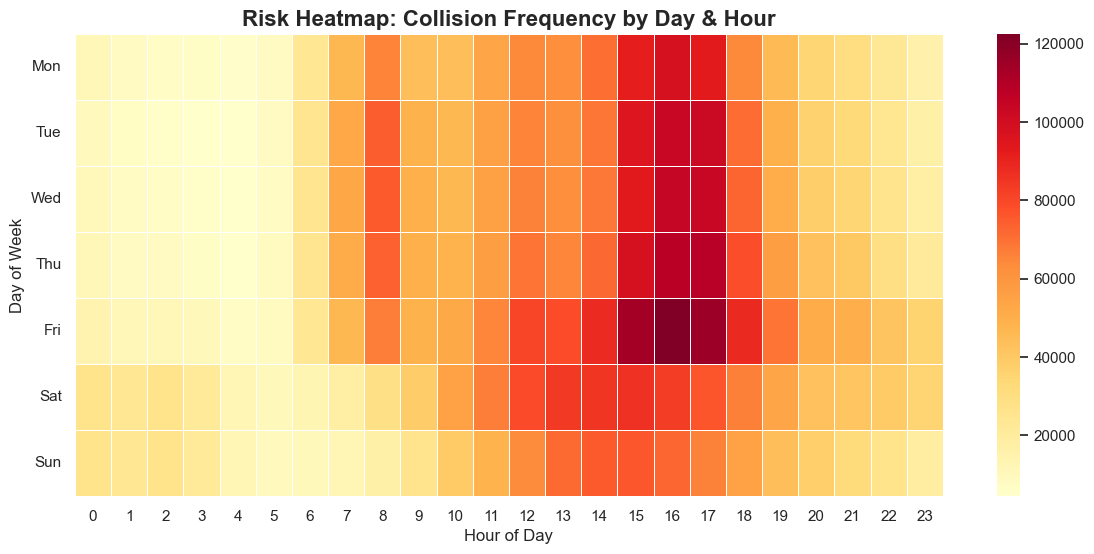

In [33]:
plt.figure(figsize=(14, 6))
# 1=Mon, 7=Sun (Standard NCDB mapping)
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"] 
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=.5, yticklabels=day_labels)
plt.title("Risk Heatmap: Collision Frequency by Day & Hour", fontsize=16, fontweight='bold')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.yticks(rotation=0)
plt.show()

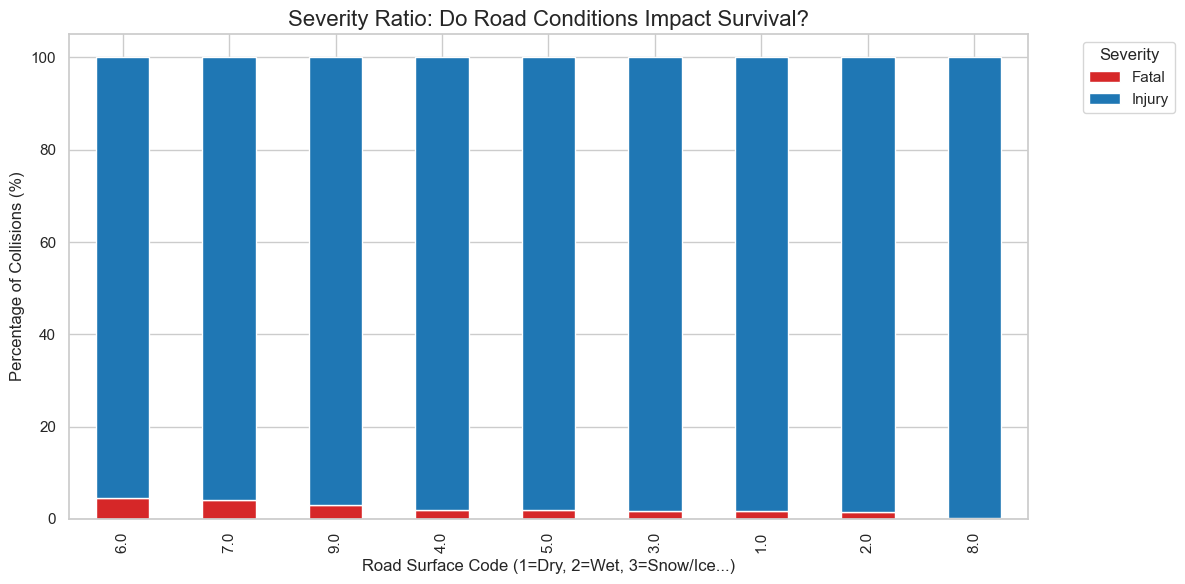

In [34]:
if 'C_RSUR' in df_final.columns:
    # Create a crosstab normalized by index (row) to get percentages
    road_risk = pd.crosstab(
        df_final['C_RSUR'], 
        df_final['Severity_Label'], 
        normalize='index'
    ) * 100
    
    # Sort by Fatality rate to see the most dangerous surfaces
    if "Fatal" in road_risk.columns:
        road_risk = road_risk.sort_values("Fatal", ascending=False)

    road_risk.plot(kind='bar', stacked=True, color=['#d62728', '#1f77b4'], figsize=(12, 6))
    plt.title("Severity Ratio: Do Road Conditions Impact Survival?", fontsize=16)
    plt.ylabel("Percentage of Collisions (%)")
    plt.xlabel("Road Surface Code (1=Dry, 2=Wet, 3=Snow/Ice...)")
    plt.legend(title="Severity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

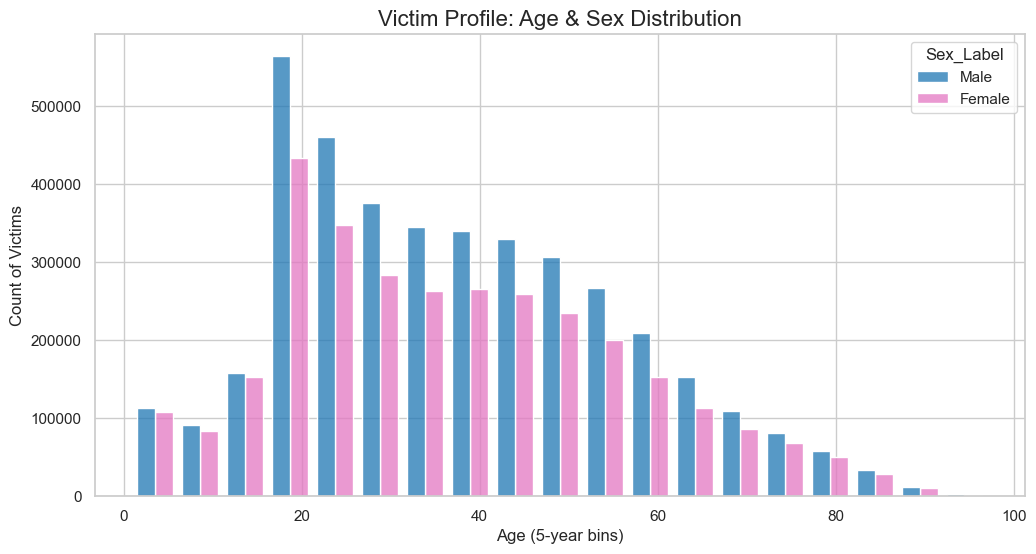

In [35]:
plt.figure(figsize=(12, 6))
age_sex_data = df_final[
    (df_final["Sex_Label"].isin(["Male", "Female"])) & 
    (df_final["P_AGE"].notna())
]

sns.histplot(
    data=age_sex_data, 
    x="P_AGE", 
    hue="Sex_Label", 
    multiple="dodge", # Side-by-side bars
    binwidth=5, 
    palette={"Male": "#1f77b4", "Female": "#e377c2"},
    shrink=.8
)
plt.title("Victim Profile: Age & Sex Distribution", fontsize=16)
plt.xlabel("Age (5-year bins)")
plt.ylabel("Count of Victims")
plt.show()

Executive Summary
The data reveals a critical misalignment between typical blood donation patterns and trauma demand.

The Problem: Trauma demand peaks in Summer and Late Autumn—precisely when donor attendance typically drops ("Summer Slump").

The Risk Zone: The highest volume of potential trauma patients occurs on Friday afternoons (3 PM – 6 PM), creating a weekly pressure point for hospital inventory entering the weekend.

The Patient Profile: The primary demographic driver is Males aged 18–30. This group is statistically more likely to be involved in severe crashes and, due to average body size, may require higher volumes of blood products per transfusion than other demographics.